# 功夫動作分類模型訓練

使用 dataset 中的角度數據訓練分類器，辨識 4 種功夫動作：
- act1: fist (握拳式)
- act2: punch (出拳式)
- act3: kick (踢腿式)
- act4: knee (提膝式)

## 1. 匯入套件

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

print("套件載入完成！")

套件載入完成！


## 2. 讀取資料

In [2]:
# 讀取 CSV 檔案
csv_path = './dataset/pose_angles_summary_actual.csv'
df = pd.read_csv(csv_path)

print(f"總樣本數: {len(df)}")
print(f"欄位: {list(df.columns)}")
df.head(10)

總樣本數: 194
欄位: ['File_Name', 'R_Elbow_Angle', 'L_Elbow_Angle', 'R_Knee_Angle', 'L_Knee_Angle', 'R_Hip_Angle', 'L_Hip_Angle', 'Action_Type']


,File_Name,R_Elbow_Angle,L_Elbow_Angle,R_Knee_Angle,L_Knee_Angle,R_Hip_Angle,L_Hip_Angle,Action_Type
0,act1_fist_p1_1.jpg,137.487037,170.097797,178.167124,178.146972,174.201098,170.743464,act1
1,act1_fist_p1_2.jpg,138.871202,158.591052,174.922449,174.665972,170.414440,171.644344,act1
2,act1_fist_p1_3.jpg,150.922331,142.812249,169.861679,168.919561,166.255170,171.794513,act1
3,act1_fist_p1_4.jpg,152.429005,133.641754,169.501889,173.723058,166.997450,167.376224,act1
4,act1_fist_p1_5.jpg,177.401274,128.472869,172.466703,172.247792,171.033392,169.443375,act1
5,act1_fist_p1_6.jpg,160.922141,136.132582,170.914062,176.560883,167.331427,169.818030,act1
6,act1_fist_p1_7.jpg,176.428726,113.549772,174.800840,176.438979,174.634174,168.975243,act1
7,act1_fist_p1_8.jpg,178.541835,91.529993,173.374471,179.727029,179.011341,169.520927,act1
8,act1_fist_p1_10.jpg,173.510739,87.500664,173.901094,177.805410,179.960612,171.721222,act1
9,act1_fist_p1_11.jpg,154.246932,87.473585,176.295909,175.430377,178.674550,172.122998,act1


各動作類型數量:
Action_Type
act1    67
act2    63
act4    34
act3    30
Name: count, dtype: int64


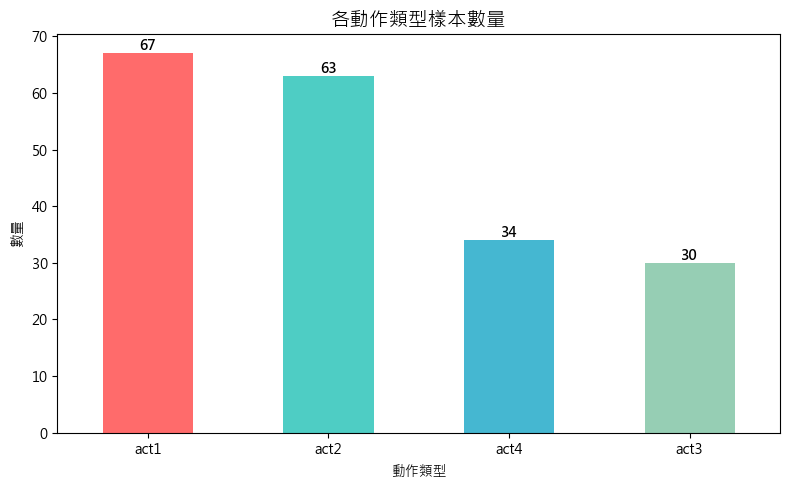

In [3]:
# 查看各動作類型數量
print("各動作類型數量:")
print(df['Action_Type'].value_counts())

# 視覺化
plt.figure(figsize=(8, 5))
ax = df['Action_Type'].value_counts().plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
plt.title('各動作類型樣本數量', fontsize=14)
plt.xlabel('動作類型')
plt.ylabel('數量')
plt.xticks(rotation=0)

# 在柱狀圖上顯示數值
for i, v in enumerate(df['Action_Type'].value_counts()):
    ax.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. 資料探索與視覺化

In [4]:
# 特徵欄位
feature_columns = [
    'R_Elbow_Angle', 'L_Elbow_Angle',
    'R_Knee_Angle', 'L_Knee_Angle',
    'R_Hip_Angle', 'L_Hip_Angle'
]

# 統計摘要
print("特徵統計摘要:")
df[feature_columns].describe()

特徵統計摘要:


,R_Elbow_Angle,L_Elbow_Angle,R_Knee_Angle,L_Knee_Angle,R_Hip_Angle,L_Hip_Angle
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,149.496139,101.815440,157.390209,153.438106,160.661089,155.536856
std,39.049068,48.494291,22.728490,32.930236,14.185091,16.384334
min,3.577238,10.593860,113.818141,45.168022,127.478357,96.650168
25%,147.618319,56.427944,133.742681,144.758375,148.554987,149.512052
50%,167.061592,91.628193,171.081372,165.088372,164.053960,160.077043
75%,170.928389,146.556297,176.266790,176.187322,172.457593,167.371088
max,179.899836,179.432661,179.952272,179.958651,179.960612,178.432319


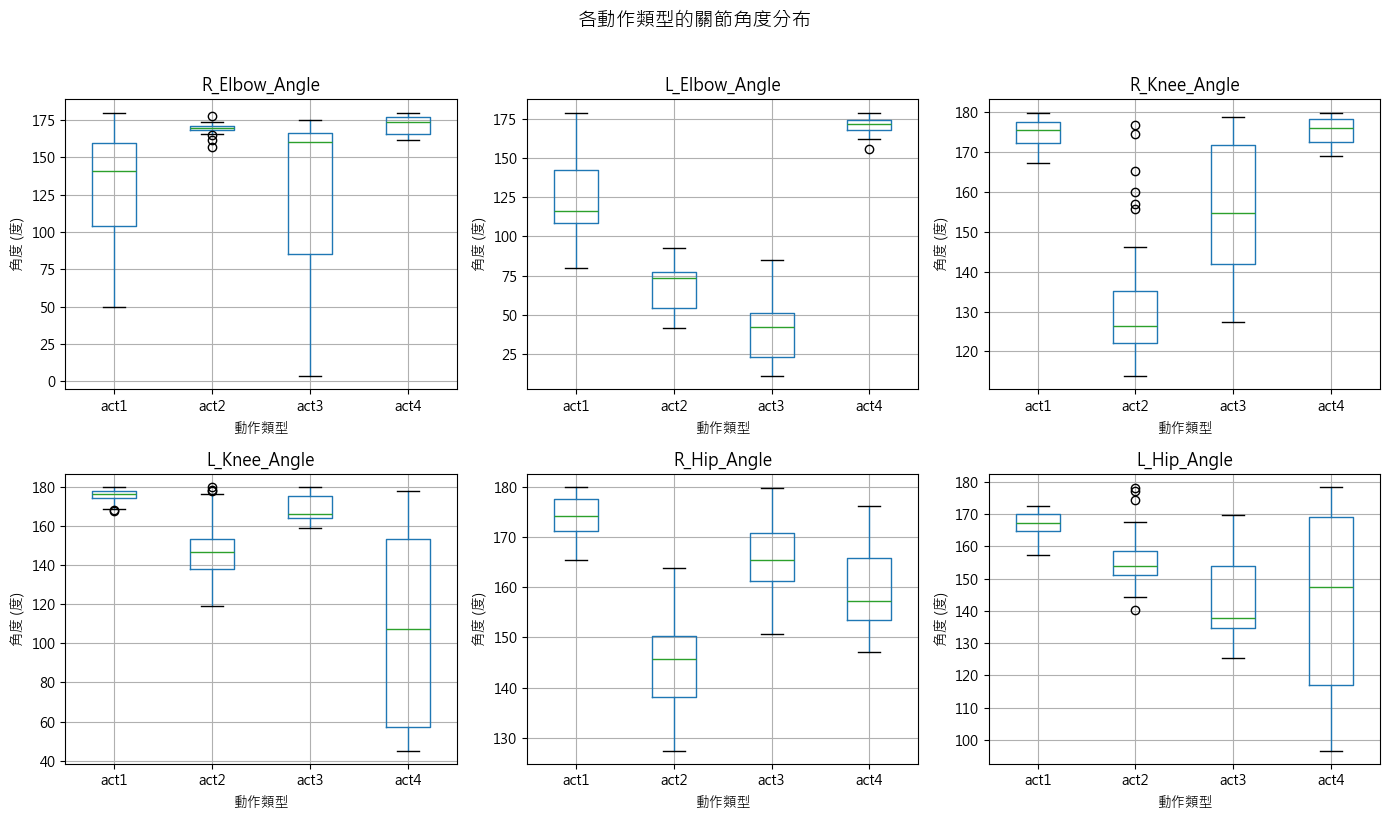

In [5]:
# 各動作類型的角度分布 (箱型圖)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

colors = {'act1': '#FF6B6B', 'act2': '#4ECDC4', 'act3': '#45B7D1', 'act4': '#96CEB4'}

for i, col in enumerate(feature_columns):
    df.boxplot(column=col, by='Action_Type', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('動作類型')
    axes[i].set_ylabel('角度 (度)')

plt.suptitle('各動作類型的關節角度分布', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

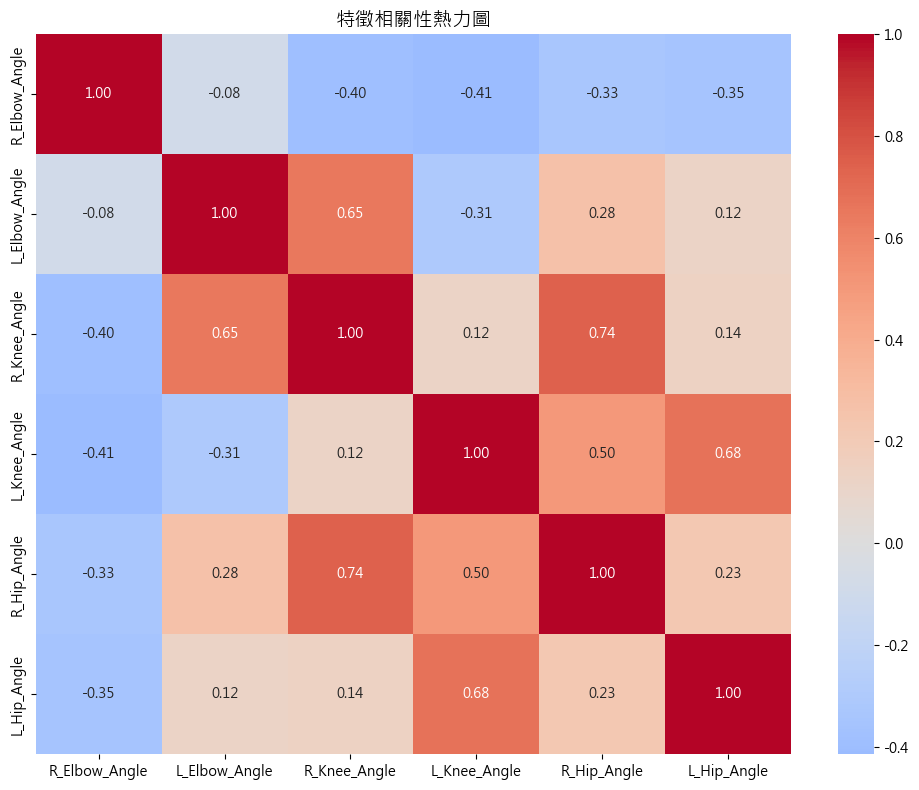

In [6]:
# 相關性熱力圖
plt.figure(figsize=(10, 8))
correlation = df[feature_columns].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('特徵相關性熱力圖', fontsize=14)
plt.tight_layout()
plt.show()

## 4. 資料預處理

In [7]:
# 準備特徵和標籤
X = df[feature_columns].values
y = df['Action_Type'].values

print(f"特徵維度: {X.shape}")
print(f"標籤數量: {len(y)}")

特徵維度: (194, 6)
標籤數量: 194


In [8]:
# 標籤編碼
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("動作類別對應:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label} -> {i}")

動作類別對應:
  act1 -> 0
  act2 -> 1
  act3 -> 2
  act4 -> 3


In [9]:
# 標準化特徵
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("標準化後的特徵統計:")
print(f"平均值: {X_scaled.mean(axis=0).round(4)}")
print(f"標準差: {X_scaled.std(axis=0).round(4)}")

標準化後的特徵統計:
平均值: [-0.  0. -0.  0.  0.  0.]
標準差: [1. 1. 1. 1. 1. 1.]


In [10]:
# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"訓練集大小: {len(X_train)}")
print(f"測試集大小: {len(X_test)}")

訓練集大小: 155
測試集大小: 39


## 5. 訓練多種分類模型

In [11]:
# 定義多種模型
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'MLP Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

print(f"將訓練 {len(models)} 種模型")

將訓練 5 種模型


In [12]:
# 訓練並評估所有模型
results = {}

for name, model in models.items():
    print(f"\n訓練 {name}...")
    
    # 訓練模型
    model.fit(X_train, y_train)
    
    # 預測
    y_pred = model.predict(X_test)
    
    # 計算準確度
    accuracy = accuracy_score(y_test, y_pred)
    
    # 交叉驗證
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred
    }
    
    print(f"  測試準確度: {accuracy:.4f}")
    print(f"  交叉驗證: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


訓練 Random Forest...
  測試準確度: 1.0000
  交叉驗證: 0.9742 (+/- 0.0241)

訓練 Gradient Boosting...
  測試準確度: 0.9487
  交叉驗證: 0.9677 (+/- 0.0289)

訓練 SVM...
  測試準確度: 0.9744
  交叉驗證: 0.9742 (+/- 0.0241)

訓練 KNN...
  測試準確度: 1.0000
  交叉驗證: 0.9871 (+/- 0.0258)

訓練 MLP Neural Network...
  測試準確度: 1.0000
  交叉驗證: 0.9742 (+/- 0.0241)


## 6. 模型比較與評估

In [14]:
# 準確度排名
print("【模型準確度排名】\n")
sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for i, (name, res) in enumerate(sorted_results, 1):
    print(f"{i}. {name}: {res['accuracy']:.4f} (CV: {res['cv_mean']:.4f})")

# 找出最佳模型
best_model_name = sorted_results[0][0]
best_model = results[best_model_name]['model']
print(f"\n最佳模型: {best_model_name}")

【模型準確度排名】

1. Random Forest: 1.0000 (CV: 0.9742)
2. KNN: 1.0000 (CV: 0.9871)
3. MLP Neural Network: 1.0000 (CV: 0.9742)
4. SVM: 0.9744 (CV: 0.9742)
5. Gradient Boosting: 0.9487 (CV: 0.9677)

最佳模型: Random Forest


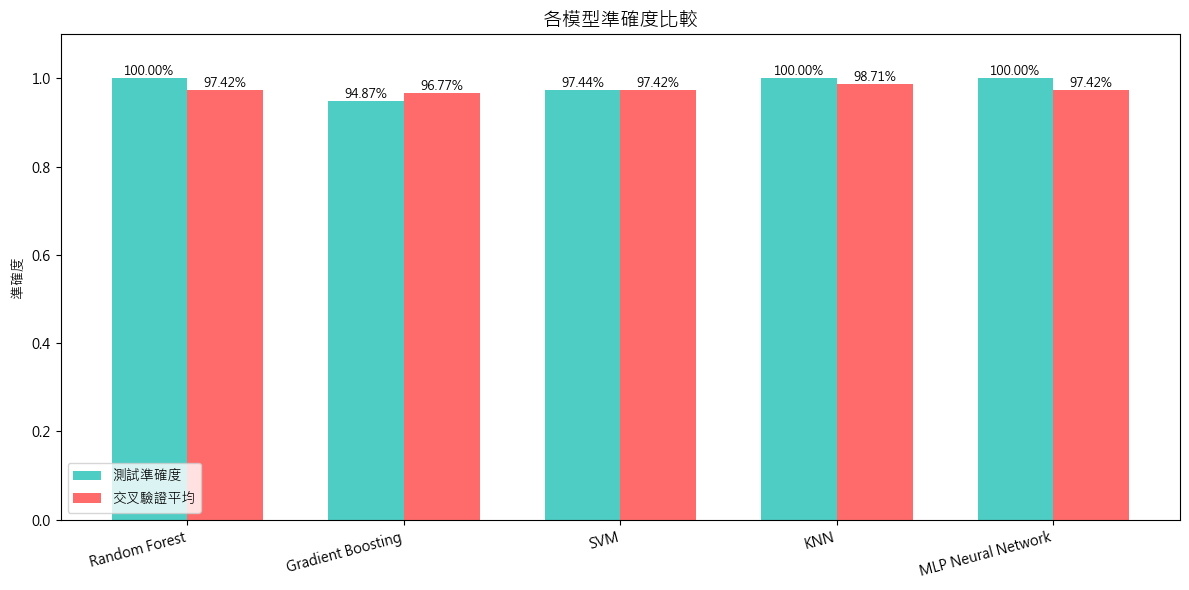

In [15]:
# 視覺化模型比較
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
cv_means = [results[name]['cv_mean'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, accuracies, width, label='測試準確度', color='#4ECDC4')
bars2 = ax.bar(x + width/2, cv_means, width, label='交叉驗證平均', color='#FF6B6B')

ax.set_ylabel('準確度')
ax.set_title('各模型準確度比較', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.set_ylim([0, 1.1])

# 顯示數值
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2%}',
            ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2%}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [16]:
# 最佳模型的詳細分類報告
print(f"【{best_model_name} 分類報告】\n")
y_pred_best = results[best_model_name]['y_pred']
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

【Random Forest 分類報告】

              precision    recall  f1-score   support

        act1       1.00      1.00      1.00        13
        act2       1.00      1.00      1.00        13
        act3       1.00      1.00      1.00         6
        act4       1.00      1.00      1.00         7

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39



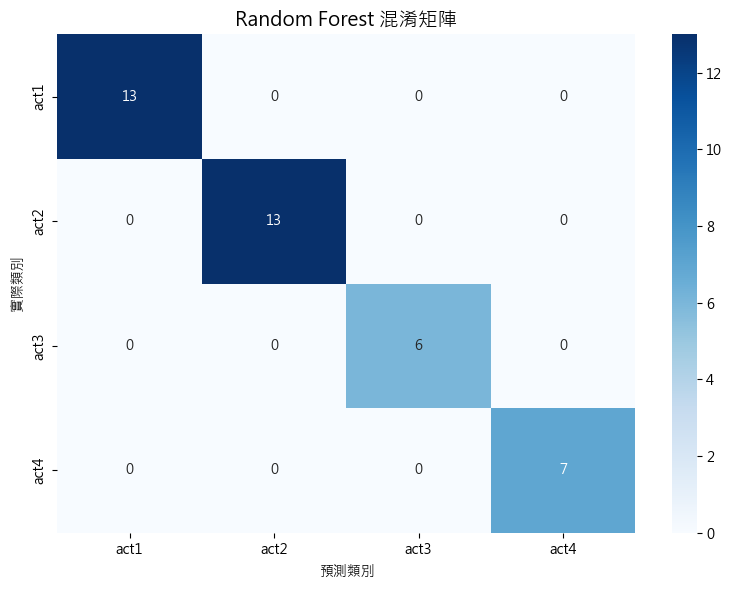

In [17]:
# 混淆矩陣視覺化
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'{best_model_name} 混淆矩陣', fontsize=14)
plt.xlabel('預測類別')
plt.ylabel('實際類別')
plt.tight_layout()
plt.show()

## 7. 儲存模型

In [18]:
# 建立 model 資料夾
save_path = Path('./model')
save_path.mkdir(parents=True, exist_ok=True)

# 儲存模型
joblib.dump(best_model, save_path / 'kungfu_classifier.joblib')
print(f"模型已儲存: {save_path / 'kungfu_classifier.joblib'}")

# 儲存 scaler
joblib.dump(scaler, save_path / 'scaler.joblib')
print(f"Scaler 已儲存: {save_path / 'scaler.joblib'}")

# 儲存 label encoder
joblib.dump(label_encoder, save_path / 'label_encoder.joblib')
print(f"Label Encoder 已儲存: {save_path / 'label_encoder.joblib'}")

# 儲存模型資訊
model_info = {
    'model_name': best_model_name,
    'feature_columns': feature_columns,
    'classes': list(label_encoder.classes_),
    'accuracy': results[best_model_name]['accuracy']
}
joblib.dump(model_info, save_path / 'model_info.joblib')
print(f"模型資訊已儲存: {save_path / 'model_info.joblib'}")

print(f"\n所有檔案已儲存至: {save_path.absolute()}")

模型已儲存: model\kungfu_classifier.joblib
Scaler 已儲存: model\scaler.joblib
Label Encoder 已儲存: model\label_encoder.joblib
模型資訊已儲存: model\model_info.joblib

所有檔案已儲存至: c:\Users\User\deskTop-1\fcu114-1\KungFu-master\model


## 8. 測試模型預測

In [19]:
# 載入模型 (模擬實際使用情境)
loaded_model = joblib.load('./model/kungfu_classifier.joblib')
loaded_scaler = joblib.load('./model/scaler.joblib')
loaded_encoder = joblib.load('./model/label_encoder.joblib')
loaded_info = joblib.load('./model/model_info.joblib')

print("模型載入成功！")
print(f"模型類型: {loaded_info['model_name']}")
print(f"可辨識動作: {loaded_info['classes']}")

模型載入成功！
模型類型: Random Forest
可辨識動作: ['act1', 'act2', 'act3', 'act4']


In [20]:
def predict_action(angles_dict):
    """
    預測功夫動作
    
    參數:
        angles_dict: 包含 6 個角度的字典
            - R_Elbow_Angle, L_Elbow_Angle
            - R_Knee_Angle, L_Knee_Angle  
            - R_Hip_Angle, L_Hip_Angle
    
    回傳:
        預測的動作類型和各類別機率
    """
    # 轉換為特徵向量
    X_new = np.array([[angles_dict[col] for col in loaded_info['feature_columns']]])
    X_new_scaled = loaded_scaler.transform(X_new)
    
    # 預測
    prediction = loaded_model.predict(X_new_scaled)
    probabilities = loaded_model.predict_proba(X_new_scaled)[0]
    
    predicted_class = loaded_encoder.inverse_transform(prediction)[0]
    
    return predicted_class, dict(zip(loaded_encoder.classes_, probabilities))

In [21]:
# 測試範例 1: kick (踢腿式) 的典型角度
test_angles_kick = {
    'R_Elbow_Angle': 155.0,
    'L_Elbow_Angle': 40.0,
    'R_Knee_Angle': 164.0,
    'L_Knee_Angle': 168.0,
    'R_Hip_Angle': 176.0,
    'L_Hip_Angle': 125.0
}

predicted, probs = predict_action(test_angles_kick)

print("【測試 1: 踢腿式角度】")
print(f"預測結果: {predicted}")
print("\n各類別機率:")
for action, prob in sorted(probs.items(), key=lambda x: x[1], reverse=True):
    bar = "█" * int(prob * 30)
    print(f"  {action}: {prob:.2%} {bar}")

【測試 1: 踢腿式角度】
預測結果: act3

各類別機率:
  act3: 96.00% ████████████████████████████
  act2: 2.00% 
  act1: 1.00% 
  act4: 1.00% 


In [22]:
# 測試範例 2: punch (出拳式) 的典型角度
test_angles_punch = {
    'R_Elbow_Angle': 170.0,
    'L_Elbow_Angle': 55.0,
    'R_Knee_Angle': 125.0,
    'L_Knee_Angle': 150.0,
    'R_Hip_Angle': 150.0,
    'L_Hip_Angle': 145.0
}

predicted, probs = predict_action(test_angles_punch)

print("【測試 2: 出拳式角度】")
print(f"預測結果: {predicted}")
print("\n各類別機率:")
for action, prob in sorted(probs.items(), key=lambda x: x[1], reverse=True):
    bar = "█" * int(prob * 30)
    print(f"  {action}: {prob:.2%} {bar}")

【測試 2: 出拳式角度】
預測結果: act2

各類別機率:
  act2: 100.00% ██████████████████████████████
  act1: 0.00% 
  act3: 0.00% 
  act4: 0.00% 


In [24]:
# 測試範例 3: knee (提膝式) 的典型角度
test_angles_knee = {
    'R_Elbow_Angle': 175.0,
    'L_Elbow_Angle': 165.0,
    'R_Knee_Angle': 175.0,
    'L_Knee_Angle': 55.0,
    'R_Hip_Angle': 155.0,
    'L_Hip_Angle': 110.0
}

predicted, probs = predict_action(test_angles_knee)

print("【測試 3: 提膝式角度】")
print(f"預測結果: {predicted}")
print("\n各類別機率:")
for action, prob in sorted(probs.items(), key=lambda x: x[1], reverse=True):
    bar = "█" * int(prob * 30)
    print(f"  {action}: {prob:.2%} {bar}")

【測試 3: 提膝式角度】
預測結果: act4

各類別機率:
  act4: 100.00% ██████████████████████████████
  act1: 0.00% 
  act2: 0.00% 
  act3: 0.00% 


## 9. 總結

### 訓練結果
- 使用 6 個關節角度特徵訓練分類模型
- 比較了 5 種不同的機器學習演算法
- 選出最佳模型並儲存

### 模型檔案
- `model/kungfu_classifier.joblib` - 分類模型
- `model/scaler.joblib` - 特徵標準化器
- `model/label_encoder.joblib` - 標籤編碼器
- `model/model_info.joblib` - 模型資訊

### 使用方式
```python
import joblib
import numpy as np

# 載入模型
model = joblib.load('./model/kungfu_classifier.joblib')
scaler = joblib.load('./model/scaler.joblib')
encoder = joblib.load('./model/label_encoder.joblib')

# 預測新數據
angles = [R_Elbow, L_Elbow, R_Knee, L_Knee, R_Hip, L_Hip]
X_scaled = scaler.transform([angles])
prediction = model.predict(X_scaled)
action = encoder.inverse_transform(prediction)[0]
```